# Moment curvature

Introduction to `sympy`, `numpy` and `scipy` showing how to write
semi-analytical models for the reinforced cross-sectional
combinations.

This notebook starts with the basic expressions for bending.

## Import modules

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
sp.init_printing()

In [2]:
from scipy.optimize import newton, brentq, root

Introduce the cross sectional curvature $\kappa$ which is equal to
\begin{align}
\kappa = \frac{\partial \varepsilon_{xx}}{\partial z}
\end{align}

In [3]:
kappa = sp.Symbol('kappa', real=True, nonpositive=True)

In [4]:
eps_top = sp.symbols(
    'varepsilon_top', real=True, nonpositive=True )
eps_bot = sp.symbols(
    'varepsilon_bot', real=True, nonnegative=True )
b, h, z = sp.symbols('b, h, z', nonnegative = True )

**Parameters of the constitutive law**

In [5]:
E_ct, E_cc, eps_cr, eps_fail, sigma_pc = sp.symbols(
    r'E_ct, E_cc, varepsilon_cr, varepsilon_fail, sigma_pc', 
    real=True, nonnegative=True
)

In [6]:
eps_yield, eps_c_fail = sp.symbols(
    r'varepsilon_y, eps_c_fail', real=True, nonpositive=True
)

**Linear profile** of strain over the height

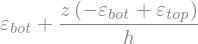

In [7]:
eps_z = eps_bot + z * (eps_top - eps_bot) / h
eps_z

## Constitutive law

In [8]:
eps = sp.Symbol('varepsilon', real=True )

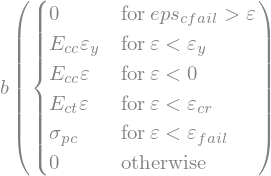

In [9]:
sig = b * sp.Piecewise(
    (0, eps < eps_c_fail),
    (E_cc * eps_yield, eps < eps_yield),
    (E_cc * eps, eps < 0), 
    (E_ct * eps, eps < eps_cr),
    (sigma_pc, eps < eps_fail),
    (0, eps >= eps_fail)
)
sig

**Define the material data:**

In [10]:
model_data = {
    b : 50,
    h : 100,
    E_ct : 24000, E_cc : 25000, 
    eps_cr : 0.001, 
    eps_yield:-0.003, 
    eps_c_fail:-0.01, 
    sigma_pc:10,
    eps_fail : 0.003
}

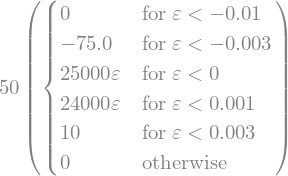

In [11]:
sig.subs(model_data)

In [12]:
get_sig_eps = sp.lambdify(eps, sig.subs(model_data), 'numpy' )

**Plot the material behavior**

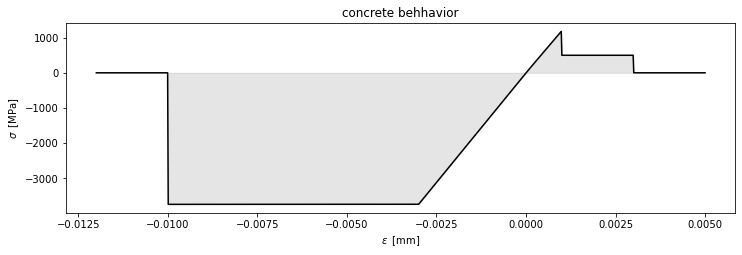

In [13]:
eps_min, eps_max = -0.012, 0.005
fig, ax1 = plt.subplots(1,1, figsize=(12,3.5)) 
eps_data = np.linspace(eps_min, eps_max, 1000)
ax1.plot(eps_data, get_sig_eps(eps_data),color='black')
ax1.fill_between(eps_data, get_sig_eps(eps_data),color='black', alpha=0.1)
ax1.set_xlabel(r'$\varepsilon\;\;\mathrm{[mm]}$'); ax1.set_ylabel(r'$\sigma\;\;\mathrm{[MPa]}$'); 
ax1.set_title('concrete behhavior');

**Stress over the cross section**

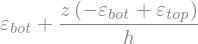

In [14]:
eps_z

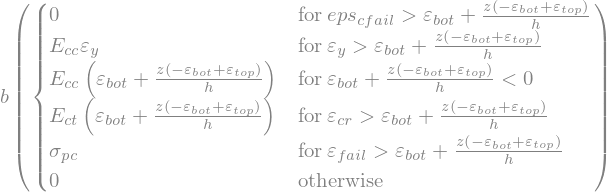

In [15]:
sig_z = sig.subs(eps, eps_z)
sig_z

Express $\varepsilon_\mathrm{top}$ as a function of $\kappa$ and $\varepsilon_\mathrm{bot}$

In [16]:
sp.solve(kappa - eps_z.diff(z), eps_top)[0]

In [17]:
subs_eps = {
    eps_top : sp.solve(kappa - eps_z.diff(z), eps_top)[0]
}
subs_eps

In [18]:
get_eps_z = sp.lambdify(
    (kappa, eps_bot, z), eps_z.subs(subs_eps), 'numpy'
)

Use the substitution in expression of stresses over the height

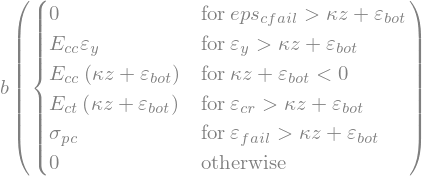

In [19]:
sig_z_lin = sig_z.subs(subs_eps)
sig_z_lin

# Reinforcement bar
Define a position of a bar $z_i$ with associated area $A_i$ and E-Modulus $E_i$.

In [20]:
z_i = np.array([10], dtype=np.float_)
A_i = np.array([[np.pi * (16/2.)**2]], dtype=np.float_)
E_i = np.array([[210000]], dtype=np.float_)

# Model data

In [21]:
model_data

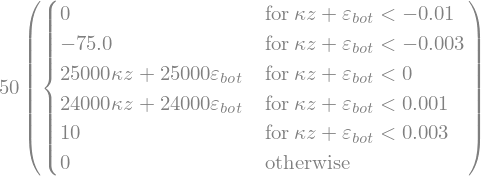

In [22]:
sig_z_lin.subs(model_data)

In [23]:
get_sig_z = sp.lambdify(
    (kappa, eps_bot, z), sig_z_lin.subs(model_data), 'numpy'
)

# Stress resultants

In [24]:
z_arr = np.linspace(0, 100, 100)

In [25]:
def get_N_s(kappa, eps_bot):
    eps_z_i = get_eps_z(
        kappa[:,np.newaxis], eps_bot[:,np.newaxis], z_i[np.newaxis,:], 
    )
    return np.sum(E_i * A_i * eps_z_i, axis=-1)
    
def get_N_c(kappa, eps_bot, get_sig_z=get_sig_z):
    zz_arr = z_arr[np.newaxis,:]
    sig_z_arr = get_sig_z(kappa[:,np.newaxis], eps_bot[:,np.newaxis], 
                          zz_arr)
    return np.trapz(sig_z_arr, x=zz_arr, axis=-1 )

def get_N(phi, eps_bot, get_sig_z=get_sig_z):
    return get_N_c(phi, eps_bot, get_sig_z) + get_N_s(phi, eps_bot)

In [26]:
def get_M_s(kappa, eps_bot):
    eps_z_i = get_eps_z(
        kappa[:,np.newaxis], eps_bot[:,np.newaxis], z_i[np.newaxis,:], 
    )
    return np.sum((E_i * A_i * eps_z_i) * z_i, axis=-1)
    
def get_M_c(kappa, eps_bot):
    zz_arr = z_arr[np.newaxis,:]
    sig_z_arr = get_sig_z(kappa[:,np.newaxis], eps_bot[:,np.newaxis], 
                          zz_arr)
    return np.trapz(sig_z_arr*zz_arr, x=zz_arr, axis=-1 )

def get_M(phi, eps_bot):
    return get_M_c(phi, eps_bot) + get_M_s(phi, eps_bot)

# Solution procedure
Find strain that renders zero normal force $N = 0$ for a given $phi$ 

In [27]:
def get_eps_bot( kappa ):
    res = root( lambda eps_bot: get_N(kappa, eps_bot), 
                  np.zeros_like(kappa), tol=1e-10 )
    return res.x 

**Define range of curvatures**

In [28]:
kappa_arr = np.linspace(-0.001,0.001,101)

In [29]:
eps_bot_arr = get_eps_bot(kappa_arr)
M_arr = get_M(kappa_arr, eps_bot_arr)
M_arr

array([  -205405.34079405,   -205040.87067898,   -204676.4005639 ,
         -246127.76605093,   -245763.29593585,   -245162.102065  ,
         -289660.7544354 ,   -288908.90527194,   -288157.05610827,
         -287405.20694461,   -335730.6016686 ,   -334979.45754294,
         -386803.09122071,   -385466.7412854 ,   -384130.3913501 ,
         -439056.99012292,   -439401.65014868,   -496040.98452779,
         -557225.41306677,   -556834.66197796,   -621845.23070675,
         -689786.76331228,   -686560.47498191,   -757531.0118564 ,
         -831239.66982775,   -907804.82058865,   -987510.10414042,
        -1069313.53329105,  -1153780.62725526,  -1339110.76204625,
        -1535669.50451605,  -1631827.83075653,  -1841394.5204177 ,
        -2189378.78174483,  -2425956.24911992,  -2810862.91544047,
        -3368051.71228007,  -3965897.14836345,  -4775756.53904162,
        -5832554.83898901,  -7399995.60307311,  -9331752.82140115,
       -12356152.25849719, -11853287.99214598, -11213495.86020

In [30]:
eps_z_arr = get_eps_z(
    kappa_arr[:,np.newaxis], eps_bot_arr[:,np.newaxis], z_arr[np.newaxis,:],
)
sig_z_arr = get_sig_z(
    kappa_arr[:,np.newaxis], eps_bot_arr[:,np.newaxis], z_arr[np.newaxis,:], 
)

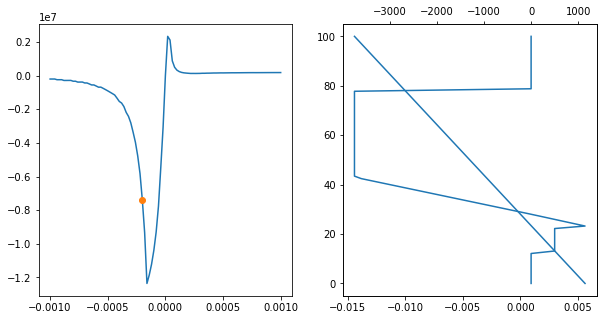

In [31]:
idx = 40
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(10,5))
ax1.plot(kappa_arr, M_arr)
ax1.plot(kappa_arr[idx], M_arr[idx], marker='o')
ax2.plot(eps_z_arr[idx,:], z_arr);
#ax2.fill_between(eps_z_arr[idx,:], z_arr, 0, alpha=0.1);
ax3 = ax2.twiny()
ax3.plot(sig_z_arr[idx,:], z_arr);
#ax3.fill_between(sig_z_arr[idx,:], z_arr, 0, alpha=0.1);

# Class maintaining state and dependencies

In [32]:
import traits.api as tr

In [33]:
class MomentCurvature(tr.HasStrictTraits):
    r'''Class returning the moment curvature relationship.
    '''
    model_params = tr.Dict({
        b : 50,
        h : 100,
        E_ct : 24000, E_cc : 25000, 
        eps_cr : 0.001, 
        eps_yield:-0.003, 
        eps_c_fail:-0.01, 
        sigma_pc:10,
        eps_fail : 0.003
    })
    
    # Reinforcement
    z_i = tr.Array(np.float_, value=[10])
    A_i = tr.Array(np.float_, value=[[np.pi * (16/2.)**2]])
    E_i = tr.Array(np.float_, value=[[210000]])
    
    z_arr = tr.Property(depends_on='model_params_items')
    @tr.cached_property
    def _get_z_arr(self):
        return np.linspace(0,self.model_params[h],100)

    kappa_range = tr.Tuple(-0.001,0.001,101)
    
    kappa = tr.Property( tr.Array(np.float_), depends_on='kappa_range' )
    @tr.cached_property
    def _get_kappa(self):
        return np.linspace(*self.kappa_range)

    get_eps_z = tr.Property(depends_on='model_params_items')
    @tr.cached_property
    def _get_get_eps_z(self):
        return sp.lambdify(
            (kappa, eps_bot, z), eps_z.subs(subs_eps), 'numpy'
        )
    
    get_sig_z = tr.Property(depends_on='model_params_items')
    @tr.cached_property
    def _get_get_sig_z(self):
        return sp.lambdify(
            (kappa, eps_bot, z), sig_z_lin.subs(self.model_params), 'numpy'
        )
    
    # Normal force
    def get_N_s(self, kappa, eps_bot):
        eps_z_i = get_eps_z(
            kappa[:,np.newaxis], eps_bot[:,np.newaxis], self.z_i[np.newaxis,:], 
        )
        return np.sum(self.E_i * self.A_i * eps_z_i, axis=-1)

    def get_N_c(self, kappa, eps_bot):
        zz_arr = self.z_arr[np.newaxis,:]
        sig_z_arr = self.get_sig_z(kappa[:,np.newaxis], eps_bot[:,np.newaxis], 
                                  zz_arr)
        return np.trapz(sig_z_arr, x=zz_arr, axis=-1 )

    def get_N(self, kappa, eps_bot):
        return get_N_c(kappa, eps_bot) + get_N_s(kappa, eps_bot)    
 
    eps_bot = tr.Property()
    r'''Resolve the tensile strain to get zero normal force 
    for the prescribed curvature
    '''
    def _get_eps_bot( self ):
        res = root( lambda eps_bot: self.get_N(self.kappa, eps_bot), 
                      np.zeros_like(self.kappa), tol=1e-10 )
        return res.x 
    
    M_s = tr.Property()
    def _get_M_s(self):
        eps_z_i = self.get_eps_z(
            self.kappa[:,np.newaxis], self.eps_bot[:,np.newaxis], 
            self.z_i[np.newaxis,:], 
        )
        return np.sum((self.E_i * self.A_i * eps_z_i) * self.z_i, axis=-1)

    M_c = tr.Property()
    def _get_M_c(self):
        zz_arr = self.z_arr[np.newaxis,:]
        sig_z_arr = self.get_sig_z(
            self.kappa[:,np.newaxis], self.eps_bot[:,np.newaxis], zz_arr)
        return np.trapz(sig_z_arr*zz_arr, x=zz_arr, axis=-1 )

    M_arr = tr.Property()
    def _get_M_arr(self):
        return self.M_c + self.M_s
    
    eps_z_arr = tr.Property()
    def _get_eps_z_arr(self):
        return get_eps_z(
            self.kappa[:,np.newaxis], self.eps_bot[:,np.newaxis], 
            self.z_arr[np.newaxis,:],
        )
    
    sig_z_arr = tr.Property()
    def _get_sig_z_arr(self):
        return get_sig_z(
            self.kappa[:,np.newaxis], self.eps_bot[:,np.newaxis], 
            self.z_arr[np.newaxis,:], 
        )
    
    idx = tr.Int(0)
    def plot(self):
        idx = self.idx
        fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(10,5))
        ax1.plot(self.kappa, self.M_arr)
#         ax1.plot(self.kappa, self.M_arr, 'tab:orange'),  ax1.set(title= 'Moment Curvature', xlabel=r'$\phi$', ylabel='$M$')

        ax1.fill_between(self.kappa, self.M_arr, 0, alpha=0.1);
        
        ax1.plot(self.kappa[idx], self.M_arr[idx], marker='o')
        
        ax2.plot(self.eps_z_arr[idx,:], self.z_arr);
#         ax2.plot(self.eps_z_arr[idx,:], self.z_arr, 'tab:red'),  ax2.set(title= 'stress_strain_cross section position', xlabel='$\z$', ylabel=r'$sigma$')

        ax2.fill_between(self.eps_z_arr[idx,:], self.z_arr, 0, alpha=0.1);
        ax3 = ax2.twiny()
        ax3.plot(self.sig_z_arr[idx,:], self.z_arr);
#         ax3.plot((self.sig_z_arr[idx,:], self.z_arr, 'tab:blue'),  ax3.set(xlabel=r'$\sigma$')

        ax3.fill_between(sig_z_arr[idx,:], z_arr, 0, alpha=0.1);
        fig.tight_layout() 
        fig.autofmt_xdate()

In [34]:
kappa_arr

array([-1.0e-03, -9.8e-04, -9.6e-04, -9.4e-04, -9.2e-04, -9.0e-04,
       -8.8e-04, -8.6e-04, -8.4e-04, -8.2e-04, -8.0e-04, -7.8e-04,
       -7.6e-04, -7.4e-04, -7.2e-04, -7.0e-04, -6.8e-04, -6.6e-04,
       -6.4e-04, -6.2e-04, -6.0e-04, -5.8e-04, -5.6e-04, -5.4e-04,
       -5.2e-04, -5.0e-04, -4.8e-04, -4.6e-04, -4.4e-04, -4.2e-04,
       -4.0e-04, -3.8e-04, -3.6e-04, -3.4e-04, -3.2e-04, -3.0e-04,
       -2.8e-04, -2.6e-04, -2.4e-04, -2.2e-04, -2.0e-04, -1.8e-04,
       -1.6e-04, -1.4e-04, -1.2e-04, -1.0e-04, -8.0e-05, -6.0e-05,
       -4.0e-05, -2.0e-05,  0.0e+00,  2.0e-05,  4.0e-05,  6.0e-05,
        8.0e-05,  1.0e-04,  1.2e-04,  1.4e-04,  1.6e-04,  1.8e-04,
        2.0e-04,  2.2e-04,  2.4e-04,  2.6e-04,  2.8e-04,  3.0e-04,
        3.2e-04,  3.4e-04,  3.6e-04,  3.8e-04,  4.0e-04,  4.2e-04,
        4.4e-04,  4.6e-04,  4.8e-04,  5.0e-04,  5.2e-04,  5.4e-04,
        5.6e-04,  5.8e-04,  6.0e-04,  6.2e-04,  6.4e-04,  6.6e-04,
        6.8e-04,  7.0e-04,  7.2e-04,  7.4e-04,  7.6e-04,  7.8e

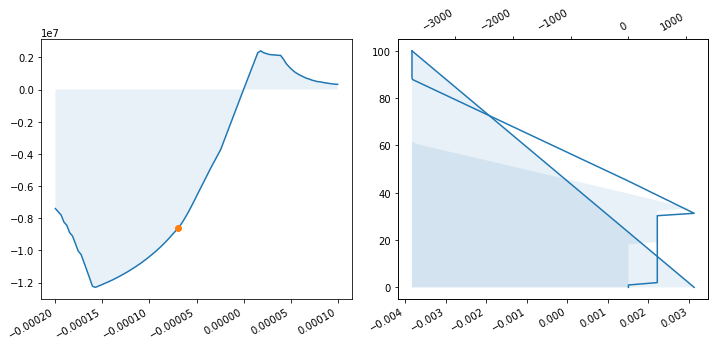

In [35]:
mc = MomentCurvature(idx=43, kappa_range=(-0.0002,0.0001,100))
mc.plot()

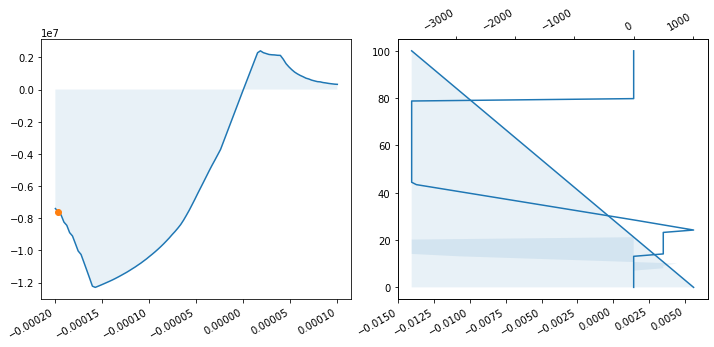

In [36]:
import ipywidgets as ipw
n_steps = 1000
mcargs_sliders = {
    name : ipw.FloatSlider(description=desc, value=val, 
                            min=minval, max=maxval, step=(maxval-minval) / n_steps, readout_format='.3f',
                           continuous_update=False)
    for name, desc, val, minval, maxval in [
        ('kappa_min', r'\(\kappa_\mathrm{min}\;\)[-]', -0.003, -0.003 , 0.003), 
        ('kappa_max', r'\(\kappa_\mathrm{max}\;\)[-]', 0.003, 0.003, 0.006),
    ]
}

mcargs_sliders['n_steps'] = ipw.IntSlider(description='$n_\mathrm{steps}$', value=10,
                             min=10, max=1000, step=10, continuous_update=False)

mcargs_sliders['idx'] = ipw.IntSlider(description='$idx$', value=0,
                             min=0, max=100, step=1, continuous_update=False)

mc_args = ['idx', 'kappa_min','kappa_max', 'n_steps']
 
def init():
    for key, sl in mcargs_sliders.items():
        globals()[key] = sl.value
    mc =  MomentCurvature(idx=1, kappa_range=(-0.0002,0.0001,100))
#     progress.max = margs_sliders['sig_cu'].value
    mc.plot()

# current_sig_m_x_K = []
# current_x = []
# def reset_crack_slider(x, sig_m_x_K):
#     global current_sig_m_x_K, current_x, sig_m_line, sig_eps_marker
#     current_sig_m_x_K = sig_m_x_K
#     current_x = x
#     n_cracks = len(sig_m_x_K)
#     crack_slider.max = n_cracks-1
#     crack_slider.value = 0
#     sig_m_line, = ax_sig_x.plot(x, sig_m_x_K[0])
#     sig_eps_marker, = ax.plot([0],[0],color='magenta',marker='o')
    
# def update_crack_slider(crack):
#     global sig_m_line, sig_eps_marker
#     global sig_c_K, eps_c_K
#     if len(current_sig_m_x_K) > 0:
#         sig_m_line.set_ydata(current_sig_m_x_K[crack])
#     sig_eps_marker.set_data(eps_c_K[crack],sig_c_K[crack])



def update(**mcparams):
    global M_arr, kappa_arr
    for key, val in mcparams.items():
        globals()[key] = val
#     ax1.clear()
#     ax2.clear()
    mc =  MomentCurvature(mcparams[mc_args])
    mc.plot()


   
def slider_layout():

    mc_layout = ipw.Layout(grid_template_columns='1fr')
    mc_list = [ipw.Label('kappa range')] + \
        [mcargs_sliders[arg] for arg in mc_args]
    mc_col = ipw.GridBox(mc_list, layout=mc_layout)

    alg_params = ipw.HBox([mc_col])
    box = ipw.VBox([alg_params])
    display(box)

    
init()
slider_layout()
ipw.interactive_output(update, mcargs_sliders);
